## Join Cardinality

A pet cause of mine is proselytizing the importance of join cardinality, and preventing undetected row explosion using .merge's 'validate' argument

#### Import Libraries & Setup Engines

In [1]:
import numpy as np
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
import seaborn as sns

sql_engine = sql.create_engine('mssql+pyodbc://@localhost')

#### Read a familiar SQL table

In [2]:
c02_table = 'CO2_EMISSIONS'
pop_table = 'YEARLY_POPULATION'

In [3]:
query = f"SELECT * FROM {c02_table}"
df = pd.read_sql_query(query, sql_engine)

print('Records:', df.shape[0])
df.head(3)

Records: 260


,Year,Total,Gas Fuel,Liquid Fuel,Solid Fuel,Cement,Gas Flaring,Per Capita,L/S_Ratio
0,1751,3.0,0,0,3,0,0,NaN,0.0
1,1752,3.0,0,0,3,0,0,NaN,0.0
2,1753,3.0,0,0,3,0,0,NaN,0.0


#### Join Population Data using SQL

In [4]:
query = f"""
   SELECT A.*, B.[World Population] 
     FROM {c02_table} A
LEFT JOIN {pop_table} B
       ON A.Year = B.Year
 ORDER BY A.Year """

df_sql = pd.read_sql_query(query, sql_engine)

print('Records:', df_sql.shape[0])
df_sql.head(3)

Records: 264


,Year,Total,Gas Fuel,Liquid Fuel,Solid Fuel,Cement,Gas Flaring,Per Capita,L/S_Ratio,World Population
0,1751,3.0,0,0,3,0,0,NaN,0.0,None
1,1752,3.0,0,0,3,0,0,NaN,0.0,None
2,1753,3.0,0,0,3,0,0,NaN,0.0,None


We are getting 4 extra records, what's up with that? Notice that there are null values for World Population.. we might not have noticed this with an inner join. 

#### Let's pull the population data into it's own DataFrame

In [6]:
query = f"SELECT * FROM {pop_table}"
pop_df = pd.read_sql_query(query, sql_engine, dtype={'World Population':'int64'})

print('Records:', pop_df.shape[0])
pop_df.head(3)

Records: 74


,Year,World Population,Yearly\nChange,Net\nChange,Density\n(P/Km²),Urban\nPop,Urban\nPop %
0,2020,7794798739,1.05 %,"81,330,639",52.0,"4,378,993,944",56 %
1,2019,7713468100,1.08 %,"82,377,060",52.0,"4,299,438,618",56 %
2,2018,7631091040,1.10 %,"83,232,115",51.0,"4,219,817,318",55 %


#### Now let's perform this join using .merge()
It is good practice to utilize the 'validate' argument, which will throw an error if the cardinality is off.  We are expecting a 1:1 join here. 

In [7]:
try: mrg_df = df.merge(pop_df[['Year', 'World Population']], validate='1:1')
except Exception as e: print(e)

Merge keys are not unique in right dataset; not a one-to-one merge


Looks like we got an error here, and it points us in the right direction! Much better than a quiet failure. 

#### Let's see why the right df's keys are not unique

In [8]:
key_vals = pd.DataFrame(pop_df['Year'].value_counts())
key_vals[key_vals['Year']!=1]

,Year
2010,5


Aha, there are multiple records for 2010, let's pretend that was not expected! 

In [9]:
pop_df[pop_df['Year']==2010]

,Year,World Population,Yearly\nChange,Net\nChange,Density\n(P/Km²),Urban\nPop,Urban\nPop %
10,2010,6956823603,1.22 %,"84,056,510",47.0,"3,594,868,146",52 %
11,2010,999,None,None,NaN,None,None
12,2010,999,None,None,NaN,None,None
13,2010,999,None,None,NaN,None,None
14,2010,999,None,None,NaN,None,None


#### Handle erroneous records
We know that the Earth's human population was basically never 999, we can drop these records entirely for the whole df 

In [10]:
pop_df = pop_df[pop_df['World Population']!=999].copy()

#### Now we have ensured the proper join cardinality, thanks 'validate'! 

In [11]:
mrg_df = df.merge(pop_df[['Year', 'World Population']], validate='1:1')
mrg_df.head()

,Year,Total,Gas Fuel,Liquid Fuel,Solid Fuel,Cement,Gas Flaring,Per Capita,L/S_Ratio,World Population
0,1951,1767.0,115,479,1129,20,24,0.69,0.424269,2584034261
1,1952,1795.0,124,504,1119,22,26,0.68,0.450402,2630861562
2,1953,1841.0,131,533,1125,24,27,0.69,0.473778,2677608960
3,1954,1865.0,138,557,1116,27,27,0.69,0.499104,2724846741
4,1955,2042.0,150,625,1208,30,31,0.74,0.517384,2773019936


Note: Sometimes it is necessary or beneficial to perform joins in SQL.  In these cases, it's a good idea to just manually check that any unique join keys are actually unique beforehand.. or at the very least check that you're getting the appropriate volume. 

#### Let's plot Emissions & Population on dual axes

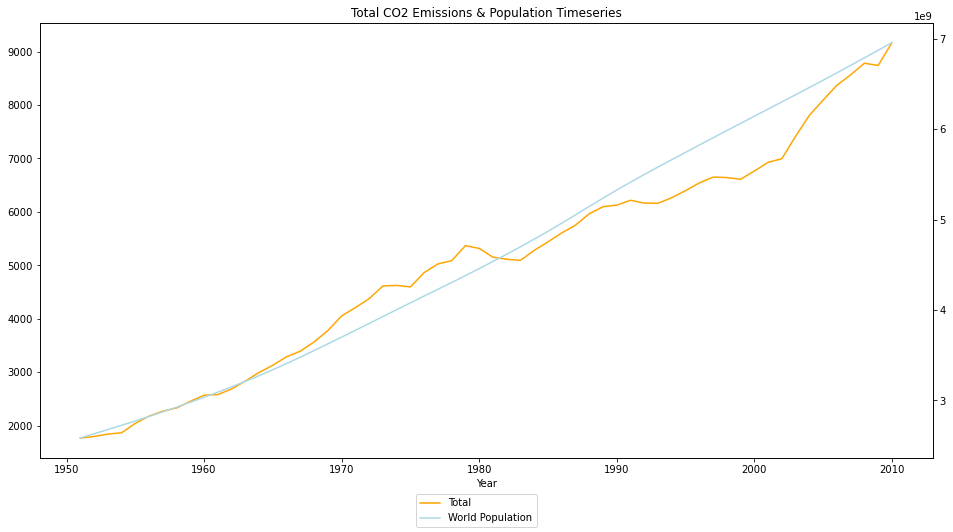

In [59]:
ax = mrg_df.plot(x='Year', y='Total', legend=False, color="orange")
ax2 = ax.twinx()
mrg_df.plot(x='Year', y='World Population', legend=False, color="lightblue", ax=ax2)

ax.set_title('Total CO2 Emissions & Population Timeseries')
ax.figure.set_size_inches(16,8)
ax.figure.legend(loc='lower center')
plt.show()

Now we have an idea of how they move together over time 